<a href="https://colab.research.google.com/github/amartyanambiar/BERT-TextClassify/blob/colab/multi_class_text_classfication.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Multi-class Text Classfication

In [ ]:
!pip install transformers

In [6]:
import pandas as pd
import transformers

In [7]:
df = pd.read_csv('https://raw.githubusercontent.com/amartyanambiar/BERT-TextClassify/main/data/final.csv')
df.head()

,short_description,category
0,One man's claims that he scammed people on the...,TECH
1,"Maury Wills, who helped the Los Angeles Dodger...",SPORTS
2,"For the past 18 months, Hollywood has effectiv...",ENTERTAINMENT
3,President issues vow as tensions with China rise.,POLITICS
4,An annual celebration took on a different feel...,POLITICS


In [8]:
from transformers import DistilBertTokenizer, TFDistilBertForSequenceClassification, TextClassificationPipeline
import tensorflow as tf
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [9]:
df.shape

(60145, 2)

<BarContainer object of 4 artists>

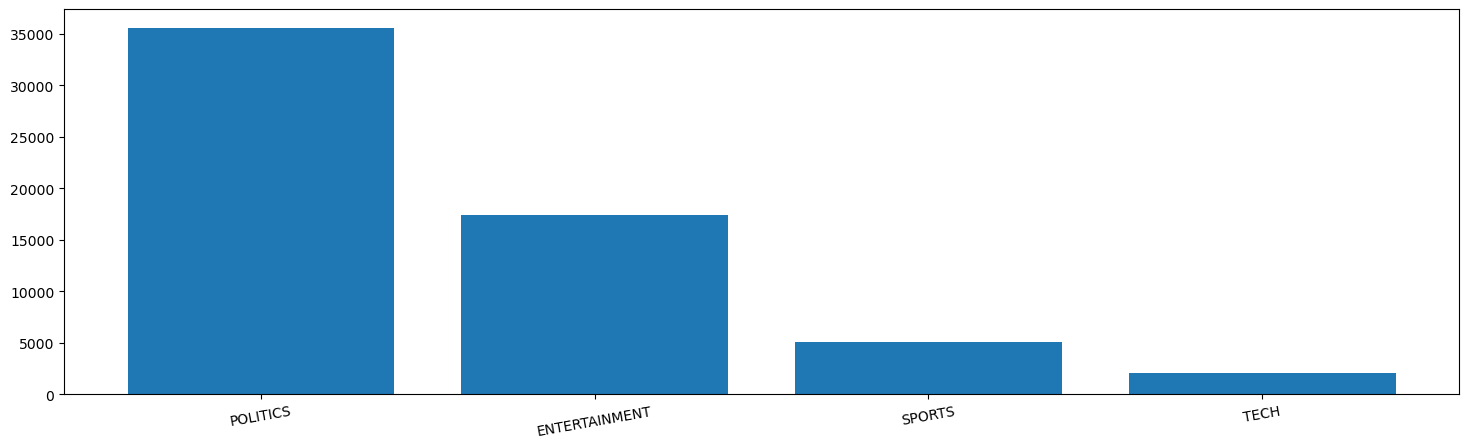

In [10]:
category_count = df['category'].value_counts()
plt.figure(figsize=(18,5))
plt.xticks(rotation = 10)
plt.bar(category_count.index,category_count.values)


In [11]:
category_count #select SPORTS,TECH,POLITICS, ENTERTAINMENT

POLITICS         35602
ENTERTAINMENT    17362
SPORTS            5077
TECH              2104
Name: category, dtype: int64

In [12]:
df['encoded_cat'] = df['category'].astype('category').cat.codes
df.head()

,short_description,category,encoded_cat
0,One man's claims that he scammed people on the...,TECH,3
1,"Maury Wills, who helped the Los Angeles Dodger...",SPORTS,2
2,"For the past 18 months, Hollywood has effectiv...",ENTERTAINMENT,0
3,President issues vow as tensions with China rise.,POLITICS,1
4,An annual celebration took on a different feel...,POLITICS,1


In [14]:
df['short_description'].isna().sum()

6413

In [15]:
df = df.dropna()

In [17]:
df['short_description'].isna().sum()

0

In [26]:
df['category'].unique()

array(['TECH', 'SPORTS', 'ENTERTAINMENT', 'POLITICS'], dtype=object)

In [18]:
headlines = df['short_description'].tolist()
category = df['encoded_cat'].tolist()

In [17]:
for element in headlines:
    if not isinstance(element, str):
        print(element)

In [19]:
len(headlines)

53732

In [20]:
train_headlines, val_headlines, train_category, val_category = train_test_split(headlines, category, test_size=0.15, random_state=42)
# for inference
train_headlines, test_headlines, train_category, test_category = train_test_split(train_headlines,train_category, test_size=0.1765, random_state=42)

In [21]:
print("Length of Train: ",len(train_headlines),",  Validatiion: ",len(val_headlines),",  Test: ",len(test_headlines))

Length of Train:  37610 ,  Validatiion:  8060 ,  Test:  8062


In [22]:
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
train_encodings = tokenizer(train_headlines, padding=True, truncation=True)
val_encodings = tokenizer(val_headlines, padding=True, truncation=True)

In [23]:
train_dataset = tf.data.Dataset.from_tensor_slices((dict(train_encodings),train_category))
val_dataset = tf.data.Dataset.from_tensor_slices((dict(val_encodings),val_category))

In [24]:
from transformers import TFDistilBertForSequenceClassification, TFTrainer, TFTrainingArguments
model = TFDistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=4)

training_args = TFTrainingArguments(
    output_dir = './results',
    num_train_epochs = 7,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=64,
    warmup_steps = 500,
    weight_decay =1e-5,
    logging_dir='./logs',
    eval_steps =100
)

with training_args.strategy.scope():
  trainer_model = TFDistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased')

trainer = TFTrainer(
    model = trainer_model,
    args = training_args,
    train_dataset = train_dataset,
    eval_dataset = val_dataset
)

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertForSequenceClassification: ['activation_13', 'vocab_projector', 'vocab_transform', 'vocab_layer_norm']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier', 'pre_classifier', 'dropout_19']
You should probably TRAIN this model on a down-stream task to be able to use i

  ········································


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [ ]:
trainer.train()

In [ ]:
trainer.evaluate()

In [ ]:
save_directory = "/saved_models" 

model.save_pretrained(save_directory)

tokenizer.save_pretrained(save_directory)

In [ ]:
tokenizer_fine_tuned = DistilBertTokenizer.from_pretrained(save_directory)

model_fine_tuned = TFDistilBertForSequenceClassification.from_pretrained(save_directory)

In [ ]:
test_text = test_headlines[0]

In [ ]:
test_category[0]

In [ ]:
predict_input = tokenizer_fine_tuned.encode(
    test_text,
    truncation = True,
    padding = True,
    return_tensors = 'tf'    
)

output = model_fine_tuned(predict_input)[0]

prediction_value = tf.argmax(output, axis = 1).numpy()[0]

prediction_value

In [46]:
import torch

from transformers import DistilBertForSequenceClassification

tokenizer_fine_tuned_pt = DistilBertTokenizer.from_pretrained(save_directory)


model_fine_tuned_pt = DistilBertForSequenceClassification.from_pretrained(save_directory, from_tf = True )

All TF 2.0 model weights were used when initializing DistilBertForSequenceClassification.

All the weights of DistilBertForSequenceClassification were initialized from the TF 2.0 model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use DistilBertForSequenceClassification for predictions without further training.


In [48]:
predict_input_pt = tokenizer_fine_tuned_pt(test_text, truncation = True, padding = True, return_tensors = 'pt' )

ouput_pt = model_fine_tuned_pt(predict_input_pt)

prediction_value_pt = torch.argmax(ouput_pt[0], dim = 1 ).item()

prediction_value_pt

AttributeError: 